# Notebook to make Fig. 2

In [0]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('colorblind')
cp2 = sns.color_palette('pastel')

from helper_functions import *

import sys
sys.path.append('../utils')
import reconstructwf as rwf

style.use('plotting.mplstyle')

### Load in data: strain timeseries

Load in time-domain data from the detectors

In [1]:
## TODO: finalize this with the real output dir
data_dir = '/Users/smiller/Documents/gw190521-timedomain-release/data_simonas_laptop/' 

data_dict =  np.load(data_dir+'LVC_strain_data.npy', allow_pickle=True).item()
wh_data_dict =  np.load(data_dir+'LVC_strain_data_whitened.npy', allow_pickle=True).item()
time_dict_data =  np.load(data_dir+'LVC_time_data.npy', allow_pickle=True).item()

Load in reconstructions and angles from before/after each cutoff time

In [2]:
reconstruction_dict = np.load(data_dir+"waveform_reconstructions_L1.npy",allow_pickle=True).item()
angles_vs_time_dict =  np.load(data_dir+'angles_vs_time_dict.npy', allow_pickle=True).item()

Define timeseries

In [3]:
# 0M <-> seconds
t0_0M_dict = {}
t0_0M_geo = 1242442967.405764
dt_10M = 0.0127 # 10 M = 12.7 ms 
dt_1M = dt_10M/10.

tstart = 1242442966.9077148
tend = 1242442967.607715

ra = 6.07546535866838
dec = -0.8000357325337637

# define t_0M in each detector in seconds
for ifo in ['H1', 'L1', 'V1']: 
    
    t_delay = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix[ifo].location, ra, dec, t0_0M_geo)
    t0_0M_dict[ifo] = t0_0M_geo + t_delay
    
# Transform timeseries into into units of M
L1_LVC_strain = data_dict['L1']
L1_LVC_strain_wh = wh_data_dict['L1']
L1_LVC_strain_bp = rwf.bandpass(L1_LVC_strain, time_dict_data['L1'], 20, 500)
L1_times_M = (time_dict_data['L1'] - t0_0M_dict['L1'])/dt_1M

reconstruction_times_M = (reconstruction_dict['time samples']- t0_0M_dict['L1'])/dt_1M

### For starters ... 

Look at waveform reconstructions at a couple of times of interest ($t=-40M$ and $t=-10M$)

In [23]:
# Define some things for plotting
colors_dict = {
    'rd m10M':'#313BD7',
    'rd m40M':'#FF3C4B',
    'full':'k'
}
x_lims_left = [-55, 70]
x_lims_center = [-100, 70]

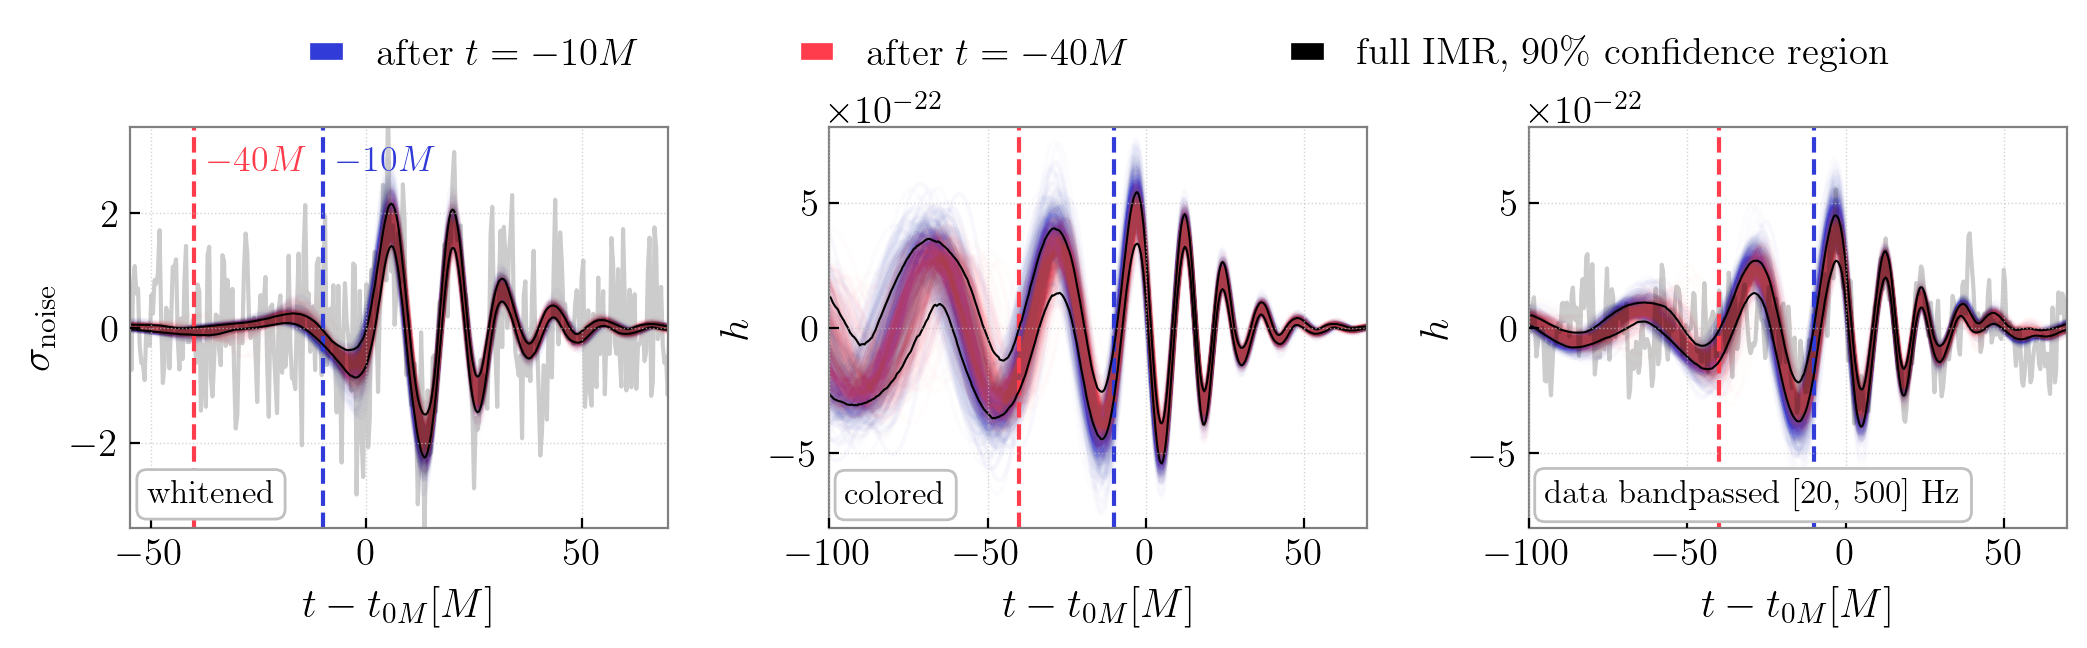

In [24]:
# Make figure
times_to_plot = ['m10M', 'm40M']
n_traces_to_plot = 500

fig, axes = plt.subplots(1, 3, figsize=(15/1.2, 25/8/1.2))

# Plot LIGO data
axes[0].plot(reconstruction_times_M, L1_LVC_strain_wh, color='k', alpha=0.2)
axes[2].plot(reconstruction_times_M, L1_LVC_strain_bp, color='k', alpha=0.2)

handles = []

for i, tc in enumerate(times_to_plot):
    
    kws=dict(color=colors_dict[f'rd {tc}'], alpha=0.01, zorder=0)

    # downsample indices to plot 
    reconstructions_wh = np.asarray(reconstruction_dict[f'rd {tc}']['wh'])
    idxs_to_plot = np.random.choice(reconstructions_wh.shape[0], size=n_traces_to_plot)
    
    # whitened reconstructions
    axes[0].plot(reconstruction_times_M, np.transpose(reconstructions_wh[idxs_to_plot,:]), **kws)

    # unwhitened reconstructions
    reconstructions_h = np.asarray(reconstruction_dict[f'rd {tc}']['h'])
    axes[1].plot(reconstruction_times_M, np.transpose(reconstructions_h[idxs_to_plot,]), **kws)
    
    # bandpassed reconstructions
    reconstructions_bp = np.asarray(reconstruction_dict[f'rd {tc}']['bp'])
    axes[2].plot(reconstruction_times_M, np.transpose(reconstructions_bp[idxs_to_plot,]), **kws)
    
    # for legend
    lbl = tc.replace('m', '-') if tc[0]=='m' else tc
    handles.append(Line2D([], [], color=colors_dict[f'rd {tc}'],label=f'after $t = {lbl}$'))
    
    # add horitonzal lines for the cutoff times
    for ax in axes:
        tc_int = -1.0*int(tc[1:-1])
        ax.axvline(tc_int, color=colors_dict[f'rd {tc}'], ls='--')
    
    axes[0].text(tc_int+3, 2.75, f'${lbl}$', color=colors_dict[f'rd {tc}'], fontsize=13)
    
# Add full waveforms
full_kws = dict(color='k', lw=0.75)
for i, run in enumerate(['wh', 'h', 'bp']):
    axes[i].plot(reconstruction_times_M, np.transpose(np.quantile(reconstruction_dict['full'][run], 
                    (0.05, 0.95), axis=0)), **full_kws)
handles.append(Line2D([], [], color='k', label=r'full IMR, 90\% confidence region'))
    
axes[0].set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes[0].set_ylabel(r'$\sigma_\mathrm{noise}$', fontsize=15)
axes[0].grid(color='silver', ls=':', alpha=0.7)
axes[0].set_xlim(*x_lims_left)
axes[0].set_ylim(-3.5, 3.5)

axes[1].set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes[1].set_ylabel(r'$h$', fontsize=15)
axes[1].grid(color='silver', ls=':', alpha=0.7)
axes[1].set_xlim(*x_lims_center)
axes[1].set_ylim(-8e-22, 8e-22)

axes[2].set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes[2].set_ylabel(r'$h$', fontsize=15)
axes[2].grid(color='silver', ls=':', alpha=0.7)
axes[2].set_xlim(*x_lims_center)
axes[2].set_ylim(-8e-22, 8e-22)

# add labels
text_kws = {'fontsize':12, 'bbox':dict(facecolor='white', edgecolor='silver', boxstyle='round')}
axes[0].text(-51, -3.05, 'whitened', **text_kws)
axes[1].text(-95, -7e-22, 'colored', **text_kws)
axes[2].text(-95, -7e-22, 'data bandpassed [20, 500] Hz', **text_kws)

# add legend
axes[1].legend(handles=handles, fontsize=14, bbox_to_anchor=(-1, 1.1, 3, .102), 
               loc='lower left', ncols=3, mode="expand", borderaxespad=0., frameon=False)
    
plt.subplots_adjust(wspace=0.3)

plt.show()

Do the same for the various angles evolving in time

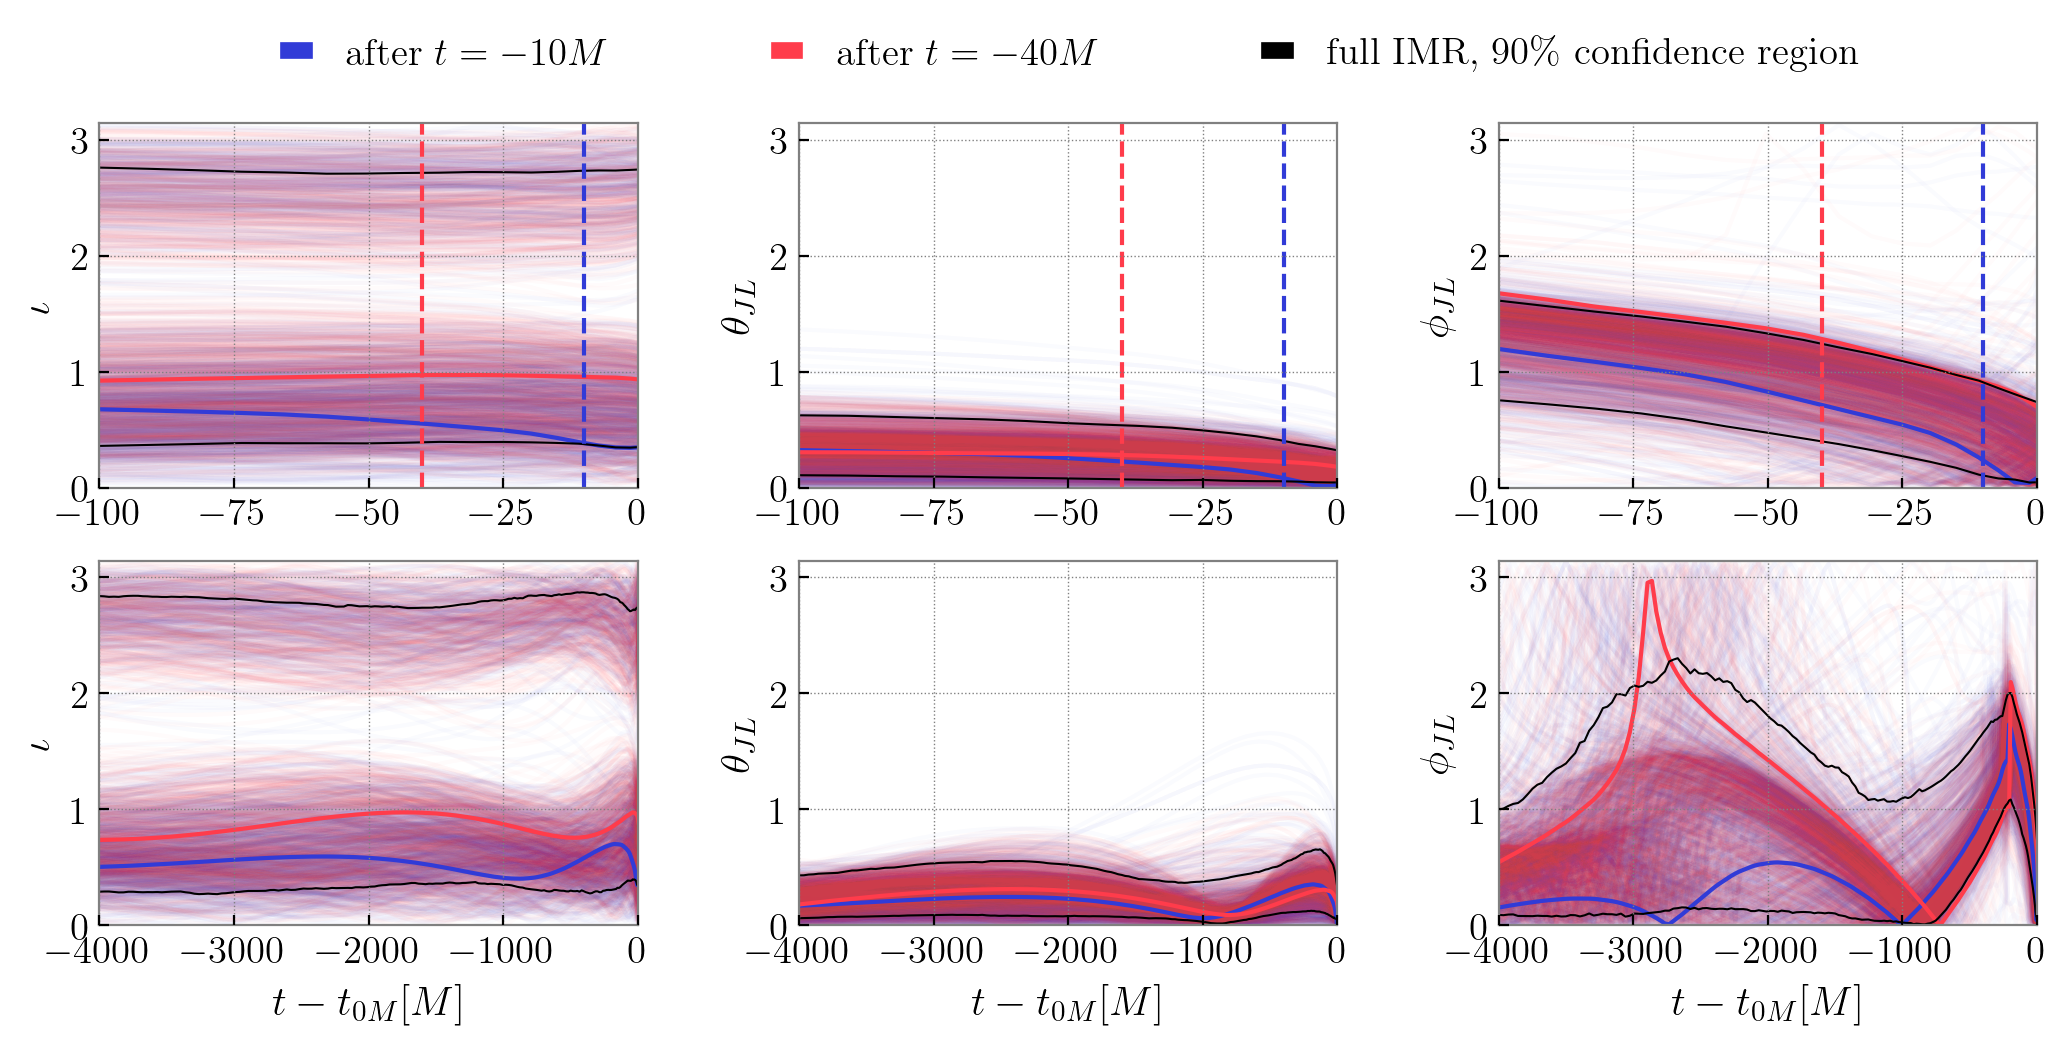

In [25]:
times_to_plot = ['m10M', 'm40M']
n_traces_to_plot = 500
angles = ['incl', 'theta_JL', 'phi_JL']

fig, axes = plt.subplots(2, 3, figsize=(15/1.2, 2*25/8/1.2))

handles = []

for i,tc in enumerate(times_to_plot): 
    
    for j, angle in enumerate(angles):
        
        for k in range(2):
    
            # plot all traces
            angle_vs_time = np.asarray(angles_vs_time_dict[f'rd {tc}'][angle])
            time = np.asarray(angles_vs_time_dict[f'rd {tc}']['time_M'])
            axes[k][j].plot(time.T, angle_vs_time.T, color=colors_dict[f'rd {tc}'], alpha=0.02, zorder=0)

            # plot maxP trace 
            imax = np.argmax(reconstruction_dict[f'rd {tc}']['params']['ln_posterior'])
            axes[k][j].plot(time[imax,:], angle_vs_time[imax,:], color=colors_dict[f'rd {tc}'], alpha=1, zorder=1)

    lbl = tc.replace('m', '-') if tc[0]=='m' else tc
    handles.append(Line2D([], [], color=colors_dict[f'rd {tc}'],label=f'after $t = {lbl}$'))
    
    
# Add full waveforms
full_kws = dict(color='k', lw=0.75)
for i, angle in enumerate(angles): 
    
    angle_vs_time = np.asarray(angles_vs_time_dict['full'][angle])
    time = np.asarray(angles_vs_time_dict['full']['time_M'])
    
    quantiles = np.quantile(angle_vs_time, (0.05, 0.95), axis=0)
    
    for k in range(2):
    
        axes[k][i].plot(time[0], quantiles.T, **full_kws)

handles.append(Line2D([], [], color='k', label=r'full IMR, 90\% confidence region'))

for ax in axes:
    for a in ax:
        a.set_ylim(0, np.pi)
        
for ax in axes[0]: 
    ax.set_xlim(-100, 0)
    ax.axvline(-10, ls='--', color=colors_dict[f'rd m10M'],)
    ax.axvline(-40, ls='--', color=colors_dict[f'rd m40M'],)
for ax in axes[1]:
    ax.set_xlim(-4000, 0)
    ax.set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)

for k in range(2):
    axes[k][0].set_ylabel(r'$\iota$', fontsize=15)
    axes[k][1].set_ylabel(r'$\theta_{JL}$', fontsize=15)
    axes[k][2].set_ylabel(r'$\phi_{JL}$', fontsize=15)

# add legend
axes[0][1].legend(handles=handles, fontsize=14, bbox_to_anchor=(-1, 1.1, 3, .102), 
               loc='lower left', ncols=3, mode="expand", borderaxespad=0., frameon=False)

plt.subplots_adjust(wspace=0.3)

plt.show()

### Now combine info from the above plots into a figure

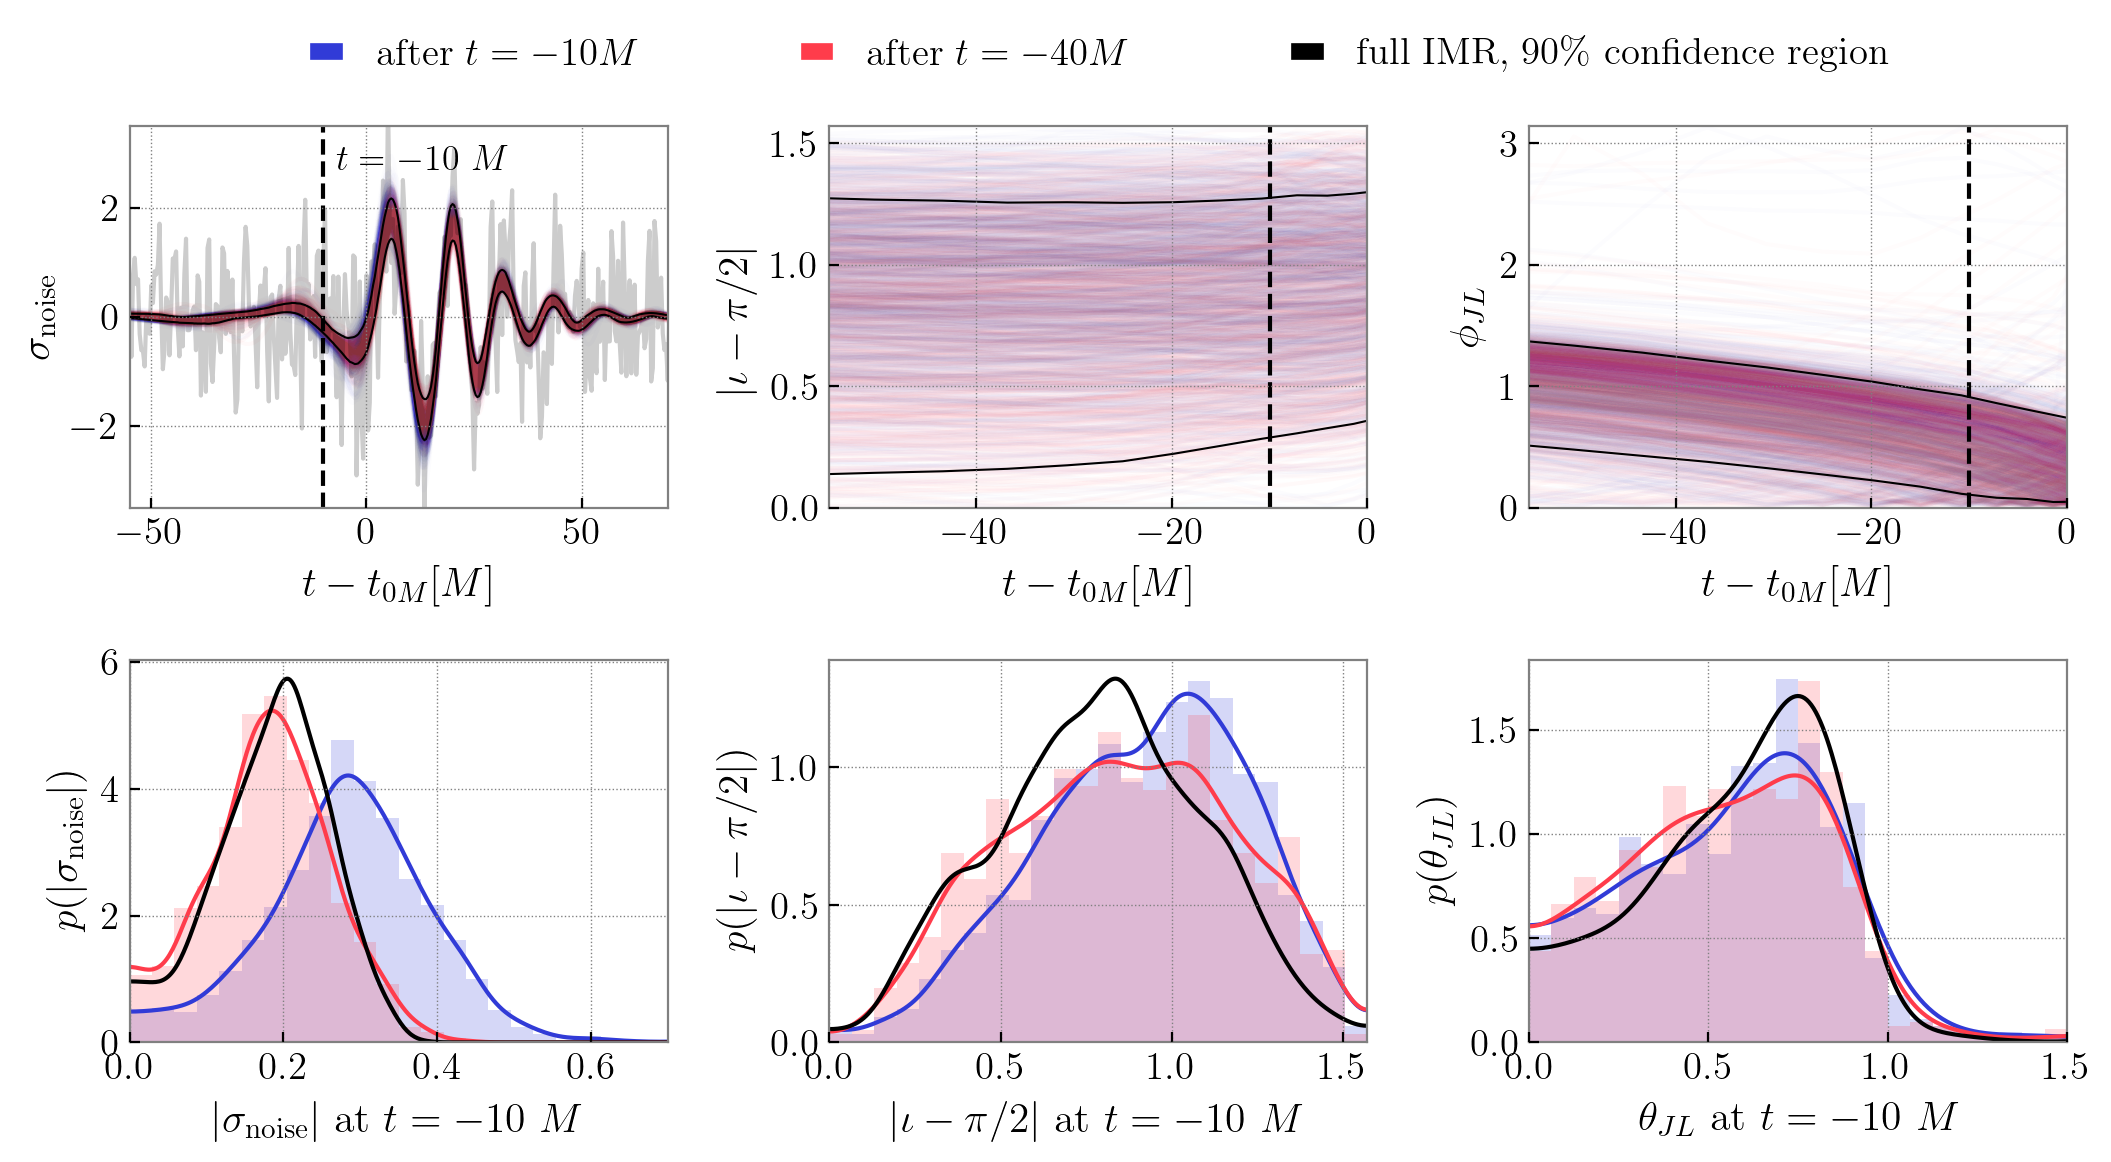

In [28]:
# Make figure
times_to_plot = ['m10M', 'm40M']
n_traces_to_plot = 500

fig, axes = plt.subplots(2, 3, figsize=(15/1.2, 25/3.5/1.2))

### TOP ROW: TIME SERIES

axes[0][0].plot(reconstruction_times_M, L1_LVC_strain_wh, color='k', alpha=0.2)

handles = []

# cycle through times
for i, tc in enumerate(times_to_plot):
    
    kws=dict(color=colors_dict[f'rd {tc}'], alpha=0.01, zorder=0)
    
    # for legend
    lbl = tc.replace('m', '-') if tc[0]=='m' else tc
    handles.append(Line2D([], [], color=colors_dict[f'rd {tc}'], label=f'after $t = {lbl}$'))
      
    # whitened reconstructions
    reconstructions_wh = np.asarray(reconstruction_dict[f'rd {tc}']['wh'])
    idxs_to_plot = np.random.choice(reconstructions_wh.shape[0], size=n_traces_to_plot)
    axes[0][0].plot(reconstruction_times_M, np.transpose(reconstructions_wh[idxs_to_plot,:]), **kws)
    
    # inclination versus time
    iota_vs_time = np.abs(np.asarray(angles_vs_time_dict[f'rd {tc}']['incl']) - np.pi/2)
    time = np.asarray(angles_vs_time_dict[f'rd {tc}']['time_M'])
    axes[0][1].plot(time.T, iota_vs_time.T, **kws)
    
    # inclination versus time
    phi_JL_vs_time = np.asarray(angles_vs_time_dict[f'rd {tc}']['phi_JL'])
    time = np.asarray(angles_vs_time_dict[f'rd {tc}']['time_M'])
    axes[0][2].plot(time.T, phi_JL_vs_time.T, **kws)
    
    
# Add full waveforms
full_kws = dict(color='k', lw=0.75)
axes[0][0].plot(reconstruction_times_M, np.transpose(np.quantile(reconstruction_dict['full']['wh'], 
                (0.05, 0.95), axis=0)), **full_kws)

for i, angle in enumerate(['incl', 'phi_JL']): 
    
    if angle=='incl':
        angle_vs_time = np.abs(np.asarray(angles_vs_time_dict['full'][angle])-np.pi/2)
    else:
        angle_vs_time = np.asarray(angles_vs_time_dict['full'][angle])
    time = np.asarray(angles_vs_time_dict['full']['time_M'])
    
    quantiles = np.quantile(angle_vs_time, (0.05, 0.95), axis=0)

    axes[0][i+1].plot(time[0], quantiles.T, **full_kws)
        
handles.append(Line2D([], [], color='k', label=r'full IMR, 90\% confidence region'))

    
axes[0][0].set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes[0][0].set_ylabel(r'$\sigma_\mathrm{noise}$', fontsize=15)
axes[0][0].set_xlim(*x_lims_left)
axes[0][0].set_ylim(-3.5, 3.5)

axes[0][1].set_ylabel(r'$|\iota - \pi/2|$', fontsize=15)
axes[0][1].set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes[0][1].set_xlim(-55, 0)
axes[0][1].set_ylim(0, np.pi/2)

axes[0][2].set_ylabel(r'$\phi_{JL}$', fontsize=15)
axes[0][2].set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes[0][2].set_xlim(-55, 0)
axes[0][2].set_ylim(0, np.pi)

# add legend
axes[0][1].legend(handles=handles, fontsize=14, bbox_to_anchor=(-1, 1.1, 3, .102), 
               loc='lower left', ncols=3, mode="expand", borderaxespad=0., frameon=False)


### BORROM ROW: HISTOGRAMS

for t, ls in zip([-10], ['-']):
    
    for run in ['rd m10M', 'rd m40M', 'full']: 
        
        c = colors_dict[run]
        
        idx = np.argmin(np.abs(reconstruction_times_M-t))
        h_posterior = np.abs(np.asarray(reconstruction_dict[run]['wh'])[:,idx])
        
        time = np.asarray(angles_vs_time_dict[run]['time_M'])
        idx = np.argmin(np.abs(time[0,:]-t))
        iota_posterior = np.abs(np.asarray(angles_vs_time_dict[run]['incl'])[:,idx] - np.pi/2)
        phiJL_posterior = np.asarray(angles_vs_time_dict[run]['phi_JL'])[:,idx]
        
        nbins = 20
        kde_kws = dict(color=c, ls=ls, lw=1.5)
        axes[1][0].plot(*reflected_kde(h_posterior, 0, 1),  **kde_kws)
        axes[1][1].plot(*reflected_kde(iota_posterior, 0, np.pi/2, bw=0.2), **kde_kws)
        axes[1][2].plot(*reflected_kde(phiJL_posterior, 0, np.pi, bw=0.3), **kde_kws)
        
        if run!='full':
            hist_kws = dict(density=True, alpha=0.2, color=c)
            nbins=25
            axes[1][0].hist(h_posterior, bins=np.linspace(0,0.7,nbins), **hist_kws)
            axes[1][1].hist(iota_posterior, bins=np.linspace(0,np.pi/2,nbins),**hist_kws)
            axes[1][2].hist(phiJL_posterior, bins=np.linspace(0,1.5,nbins), **hist_kws)

        
for i,ax in enumerate(axes[0]): 
    ax.axvline(-10, color='k', ls='--')
    
axes[0][0].text(-7, 2.7, r'$t=-10~M$', color='k', fontsize=13)

axes[1][0].set_xlabel(r'$|\sigma_\mathrm{noise}|$ at $t=-10~M$', fontsize=15)
axes[1][0].set_ylabel(r'$p(|\sigma_\mathrm{noise}|)$', fontsize=15)
axes[1][0].set_xlim(0, 0.7)
axes[1][0].set_ylim(0,)

axes[1][1].set_xlabel(r'$|\iota - \pi/2|$ at $t=-10~M$', fontsize=15)
axes[1][1].set_ylabel(r'$p(|\iota - \pi/2|)$', fontsize=15)
axes[1][1].set_xlim(0, np.pi/2)
axes[1][1].set_ylim(0,)

axes[1][2].set_xlabel(r'$\theta_{JL}$ at $t=-10~M$', fontsize=15)
axes[1][2].set_ylabel(r'$p(\theta_{JL})$', fontsize=15)
axes[1][2].set_xlim(0, 1.5)
axes[1][2].set_ylim(0,)
       
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig('figure_02.pdf', bbox_inches='tight')
plt.show()